# 线性回归从零实现

In [1]:
import random
import torch
from d2l import torch as d2l

## 1 数据集准备

人为造数据集：模型 `y=Xw+b+ϵ` 中，真值为：w=[2,−3.4]⊤、b=4.2。我们通过线性回归、梯度下降的方法来逼近真值

In [2]:
def genr_data(w, b, num_examples):  # 生成 x,y
    X = torch.normal(0, 1, (num_examples, len(w))) # 生成num_examples行，len(w)列个标准正太分布的x数值
    y = torch.matmul(X, w) + b # y=Xw+b
    y += torch.normal(0, 0.01, y.shape)  # y再加上ϵ扰动项，y=Xw+b+ϵ
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4]) # 真值
true_b = 4.2
features, labels = genr_data(true_w, true_b, 1000) # feature = x; label = y
# 现在，我们就有训练样本了

In [3]:
# 看看训练样本长什么样：
features[0], labels[0]

(tensor([0.9847, 0.6785]), tensor([3.8663]))

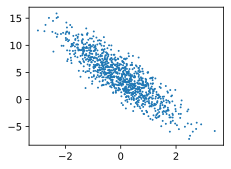

In [4]:
# 我们再来可视化一下：
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(),   # detach是因为要先从计算图中拿出来才能转成ndarray画图
                labels.detach().numpy(), 1)
# 第二列x与y的关系

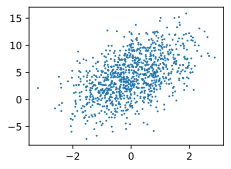

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 0].detach().numpy(), 
                labels.detach().numpy(), 1)
# 第一列x与y的关系

我们生成的数据，相当于已知的历史数据，可以用这个数据向未来作预测w、b

## 2 数据处理

[yield详解](./yield.ipynb)

In [6]:
# 实现一个函数，每次读取数据集里的一个小批量（超参数：批大小）
def data_iter(batch_size, features, labels):
    num_examples = len(features)  # 样本大小
    indexs = list(range(num_examples))   # 为每个样本生成下标
    random.shuffle(indexs)  # 把样本依照下标随机打乱，现在访问的样本都是随机的了，下一个样本是什么都是未知的。
    for i in range(0, num_examples, batch_size):  # 每次从样本中取一批数据
        batch_indexs = torch.tensor(
            indexs[i:min(i +batch_size, num_examples)])  # min 是因为最后一批的数量可能不足batch_size个，所以取到上限为止
        yield features[batch_indexs], labels[batch_indexs]

batch_size = 10 # 人为设定

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break # 打印前10个看看

tensor([[ 0.1427, -0.9593],
        [-0.2483, -0.3080],
        [-0.3666,  1.4253],
        [-0.1764,  0.3759],
        [-1.7612,  0.0254],
        [ 1.0699, -1.3822],
        [ 0.1907,  0.0519],
        [ 0.4500,  0.5015],
        [-0.1874,  0.4290],
        [ 0.3575, -0.3170]]) 
 tensor([[ 7.7540],
        [ 4.7717],
        [-1.3830],
        [ 2.5579],
        [ 0.5956],
        [11.0285],
        [ 4.4115],
        [ 3.3846],
        [ 2.3633],
        [ 5.9786]])


## 3 线性回归

现在我们有了划分好的数据集，可以开始使用线性回归的方法了

In [7]:
# 模型参数初值是随机给定的
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True) # 需要被自动微分，求得loss最小值
b = torch.zeros(1, requires_grad=True)

In [8]:
# 简单线性回归模型
def linreg(X, w, b):  
    return torch.matmul(X, w) + b  # 直接返回 Xw+b 即可

# 简单loss函数：均方误差函数，但是这里没有求均值
def loss(y_pre, y):  
    return (y_pre - y.reshape(y_pre.shape))**2 / 2

# 简单优化算法：小批量随机梯度下降
def sgd(params, lr, batch_size): # 参数（w、b）、学习率、批大小
    with torch.no_grad(): # 这里使用了 torch.no_grad() 上下文管理器，确保在更新参数时不计算梯度，从而节省内存并加快计算速度
        for param in params:
            param -= lr * param.grad / batch_size  # 这里补上求均值，适应不同批大小下的梯度幅度
            param.grad.zero_()

开始线性回归

In [9]:
lr = 0.03 # 学习率
num_epochs = 3 # 总训练轮数，即把整个数据集扫三遍
net = linreg # 使用的模型
loss = loss  # 使用的loss

for epoch in range(num_epochs):  # 第一层：每次对数据扫一遍
    for X, y in data_iter(batch_size, features, labels):  # 第二层：每次拿出一批数据
        l = loss(net(X, w, b), y)
        l.sum().backward()  # l 是个(batch_size,1)的向量，需要转成标量
        sgd([w, b], lr, batch_size)  # 梯度下降，更新w,b
    with torch.no_grad():  # 每次扫完一边数据，评价一下当前进度
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch}, loss {float(train_l.mean()):f}')

epoch 0, loss 0.032949
epoch 1, loss 0.000111
epoch 2, loss 0.000048


In [10]:
# 所有训练结束后评价一下效果：
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([0.0003, 0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0004], grad_fn=<RsubBackward1>)


## 4 总体思路总结

- 首先，我们以上帝视角知道了w、b的真实值：w=[2,−3.4]⊤、b=4.2。
- 然后，我们根据这个真实值，随机生成了1000个样本数据，即x、y对
- 接着，我们将这1000个数据随机打乱，并定义了函数，以10为大小分批处理
- 最后，我们进行模型训练，即从这1000组数据中，尝试给出w、b的真实值，并进行了loss评价。